In [72]:
# 1. Need to Get the Airport Location NY_Airport_Data [Done]

import csv
import pandas as pd
from lat_lon_parser import parse
import folium as fd
from IPython.display import HTML, display

airport_df = pd.read_csv(r'data/NY_Airport_Data.csv')
airport_df = airport_df[['ref_point_lat','ref_point_lon','objectid','fac_type','loc_id','region_code','state_name','county','fac_name']]
airport_df = airport_df[airport_df.fac_type == 'AIRPORT']
airport_df = airport_df.reset_index(drop=True)


def calculate_lat(row):
    val = parse(row['ref_point_lat'])
    return val
def calculate_lon(row):
    val = parse(row['ref_point_lon'])
    return val

airport_df['lat'] = (airport_df.apply(calculate_lat, axis=1)).round(2)
airport_df['lon'] = (airport_df.apply(calculate_lon, axis=1)).round(3)
airport_df = airport_df.reset_index(drop=True)
# v = parse("41-13-51.7000N")



In [73]:
import xarray as xr

filename_wind_nc4 = "./data/2021_JAN1_NY_Wind"
netcdf_file_name = filename_wind_nc4 + '.nc4'
csv_file_out = filename_wind_nc4 + '.csv'

ds = xr.open_dataset(('data/2021_JAN1_NY_Wind.nc4'))
df = ds.to_dataframe()
print(df.describe())
df.to_csv(csv_file_out)

import pandas as pd
import numpy as np

windspeed_df = pd.read_csv(csv_file_out)
windspeed_df = pd.DataFrame(windspeed_df)

windspeed_df = windspeed_df[['lat','lon','U2M','V2M','time']]
windspeed_df['lat'] = windspeed_df['lat'].round(2)
windspeed_df['lon'] = windspeed_df['lon'].round(2)
windspeed_df['date'] = pd.to_datetime(windspeed_df['time']).dt.date

csv_file_out_processed = filename_wind_nc4 + "_final.csv"

windspeed_df.to_csv(csv_file_out_processed)


# Compute the wind speed for the NewYork State on daily basis.....

import pandas as pd
import numpy as np

windspeed_df = pd.read_csv(csv_file_out_processed)
windspeed_df = pd.DataFrame(windspeed_df)

# print(windspeed_df)
lon = windspeed_df['lon']
lat = windspeed_df['lat']
date = windspeed_df['date']

# 2-meter eastward wind m/s
U2M = windspeed_df['U2M']
# 2-meter northward wind m/s
V2M = windspeed_df['V2M']

# Replace _FillValues with NaNs:df.replace(r'^\s*$', np.nan, regex=True)
U2M_nans = U2M[:].replace(r'^\s*$', np.nan, regex=True)
V2M_nans = V2M[:].replace(r'^\s*$', np.nan, regex=True)


# Calculate wind speed:

ws = np.sqrt(U2M_nans**2+V2M_nans**2)
list_s = [lat, lon, date]

new_df = pd.concat(list_s, axis=1)
new_df['avg_windspeed'] = ws
print(new_df.columns)
new_df = pd.DataFrame(new_df.groupby(['lat','lon']).mean()).reset_index()
new_df['date'] = date
new_df

               U2M          T2M          V2M         QV2M
count  3360.000000  3360.000000  3360.000000  3360.000000
mean     -0.325037   270.339172    -0.048653     0.002686
std       1.262722     3.522854     1.018545     0.000525
min      -7.613532   260.756714    -7.840244     0.001472
25%      -0.488761   267.633492    -0.277007     0.002314
50%      -0.137993   270.289673    -0.004459     0.002641
75%       0.212844   272.850693     0.337466     0.002993
max       4.408467   282.051697     3.237480     0.005405
Index(['lat', 'lon', 'date', 'avg_windspeed'], dtype='object')


,lat,lon,avg_windspeed,date
0,40.5,-80.00,0.551219,2021-01-01
1,40.5,-79.38,0.535491,2021-01-01
2,40.5,-78.75,0.522998,2021-01-01
3,40.5,-78.12,0.410040,2021-01-01
4,40.5,-77.50,0.336733,2021-01-01
...,...,...,...,...
135,45.0,-74.38,0.669200,2021-01-01
136,45.0,-73.75,0.531565,2021-01-01
137,45.0,-73.12,0.553786,2021-01-01
138,45.0,-72.50,0.540473,2021-01-01


In [74]:
def generate_blocks(ws_df):
    _blocks = {
        'lower_left_lat': [],
        'lower_left_lon': [],
        'upper_right_lat': [],
        'upper_right_lon': [],
        'avg_speed': [],
        'date': [],

    }
    # retrieve lat lon list
    lat_list = sorted(set(ws_df['lat'].tolist()))
    lon_list = sorted(set(ws_df['lon'].tolist()))
    date_list = (set(ws_df['date'].tolist()))
    # for loop to generate all blocks
    # todo change 'avg windspeed' to wind speed
    speed = 0
    for x in range(len(lat_list) - 1):
        for y in range(len(lon_list) - 1):
            speed += ws_df[
                (ws_df['lat'] == lat_list[x]) &
                (ws_df['lon'] == lon_list[y])]['avg_windspeed'].tolist()[0]
            speed += ws_df[
                (ws_df['lat'] == lat_list[x + 1]) &
                (ws_df['lon'] == lon_list[y])]['avg_windspeed'].tolist()[0]
            speed += ws_df[
                (ws_df['lat'] == lat_list[x]) &
                (ws_df['lon'] == lon_list[y + 1])]['avg_windspeed'].tolist()[0]
            speed += ws_df[
                (ws_df['lat'] == lat_list[x + 1]) &
                (ws_df['lon'] == lon_list[y + 1])]['avg_windspeed'].tolist()[0]

            speed = speed / 4
            _blocks['lower_left_lat'].append(lat_list[x])
            _blocks['upper_right_lat'].append(lat_list[x + 1])
            _blocks['lower_left_lon'].append(lon_list[y])
            _blocks['upper_right_lon'].append(lon_list[y + 1])
            _blocks['avg_speed'].append(speed)
            _blocks['date'].append(ws_df.loc[x,'date'])
            speed = 0
        
        
    blocks = pd.DataFrame(_blocks)
    return blocks

blocks = generate_blocks(new_df)
blocks

,lower_left_lat,lower_left_lon,upper_right_lat,upper_right_lon,avg_speed,date
0,40.5,-80.00,41.0,-79.38,0.558530,2021-01-01
1,40.5,-79.38,41.0,-78.75,0.556753,2021-01-01
2,40.5,-78.75,41.0,-78.12,0.498158,2021-01-01
3,40.5,-78.12,41.0,-77.50,0.418036,2021-01-01
4,40.5,-77.50,41.0,-76.88,0.415482,2021-01-01
...,...,...,...,...,...,...
112,44.5,-75.00,45.0,-74.38,0.524296,2021-01-01
113,44.5,-74.38,45.0,-73.75,0.502647,2021-01-01
114,44.5,-73.75,45.0,-73.12,0.495066,2021-01-01
115,44.5,-73.12,45.0,-72.50,0.496558,2021-01-01


In [75]:
airport_df = airport_df.sort_values('lat')

locations = airport_df[['lat','lon']]
wind_locations = new_df[['lat','lon']]
locations_list = locations.values.tolist()
wind_list = wind_locations.values.tolist()

map = fd.Map(location=[43, -75], zoom_start=12)

for point in range(0, len(locations_list)):
    # print(locations_list[point], point)
    fd.Marker(locations_list[point], popup=airport_df['fac_name'][point]).add_to(map)


for point in range(0, len(wind_list)):
    # print(wind_list[point], point)
    fd.Marker(wind_list[point], popup=new_df['avg_windspeed'][point], icon=fd.Icon(color='red')).add_to(map)

map.save('map.html')



In [76]:
# 3. Need to get the precipitation data and calulate the avg [Need to collect]

In [77]:
# Merge the data sets [Issues encountered]
def calculate_airport_avg_windspeed(airport_df):

    for row_id, row in airport_df.iterrows():
        lat_val = row.lat
        lon_val = row.lon
        filter1_a = lat_val >= blocks['lower_left_lat']
        filter1_b = lat_val <= blocks['upper_right_lat']
        filter2_a = lon_val >= blocks['lower_left_lon']
        filter2_b = lon_val <= blocks['upper_right_lon']
        calc_time = blocks[(filter1_a) & (filter1_b) & (filter2_a) & (filter2_b)].date.tolist()[0]
        calc_speed_temp = round(blocks[(filter1_a) & (filter1_b) & (filter2_a) & (filter2_b)].avg_speed.tolist()[0], 3)
        (airport_df.at[row_id, 'avg_calculated_windspeed']) = calc_speed_temp
        (airport_df.at[row_id, 'date']) = calc_time
    
    return airport_df
    
final_dataset_with_speed_and_airport = calculate_airport_avg_windspeed(airport_df)
final_dataset_with_speed_and_airport = final_dataset_with_speed_and_airport.reset_index(drop=True)

print(final_dataset_with_speed_and_airport)

print(final_dataset_with_speed_and_airport.date.unique())


      ref_point_lat    ref_point_lon  objectid fac_type loc_id region_code  \
0    40-38-23.7400N  073-46-43.2930W     12354  AIRPORT    JFK         AEA   
1    40-43-43.6000N  073-24-48.3000W     12173  AIRPORT    FRG         AEA   
2    40-45-27.3460N  073-03-09.6830W     12053  AIRPORT    23N         AEA   
3    40-46-38.1000N  073-52-21.4000W     12355  AIRPORT    LGA         AEA   
4    40-47-46.0885N  073-06-02.3942W     12347  AIRPORT    ISP         AEA   
..              ...              ...       ...      ...    ...         ...   
355  44-40-56.1000N  075-27-47.7000W     12371  AIRPORT    OGS         AEA   
356  44-40-36.0000N  074-56-54.4000W     12417  AIRPORT    PTD         AEA   
357  44-45-45.1460N  073-33-33.4950W     12056  AIRPORT   NY60         AEA   
358  44-51-13.2000N  074-19-44.2000W     12290  AIRPORT    MAL         AEA   
359  44-56-10.4680N  074-50-42.4310W     12299  AIRPORT    MSS         AEA   

    state_name       county                     fac_name    lat

In [78]:
final_dataset_with_speed_and_airport = final_dataset_with_speed_and_airport.sort_values('lat')

locations = final_dataset_with_speed_and_airport[['lat','lon']]
wind_locations = new_df[['lat','lon']]
locations_list = locations.values.tolist()
wind_list = wind_locations.values.tolist()

map = fd.Map(location=[43, -75], zoom_start=5)

for point in range(0, len(locations_list)):
    # print(locations_list[point], point)
    title = str(final_dataset_with_speed_and_airport['fac_name'][point]) + "," + str(final_dataset_with_speed_and_airport['avg_calculated_windspeed'][point])
    fd.Marker(locations_list[point], popup=title).add_to(map)

for point in range(0, len(wind_list)):
    # print(wind_list[point], point)
    fd.Marker(wind_list[point], popup=new_df['avg_windspeed'][point], icon=fd.Icon(color='red')).add_to(map)

map.save('airport_wind_map.html')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


    fac_type       county                     fac_name  \
0    AIRPORT       QUEENS          JOHN F KENNEDY INTL   
1    AIRPORT      SUFFOLK                     REPUBLIC   
2    AIRPORT      SUFFOLK            BAYPORT AERODROME   
3    AIRPORT       QUEENS                    LAGUARDIA   
4    AIRPORT      SUFFOLK       LONG ISLAND MAC ARTHUR   
..       ...          ...                          ...   
355  AIRPORT  ST LAWRENCE              OGDENSBURG INTL   
356  AIRPORT  ST LAWRENCE       POTSDAM MUNI/DAMON FLD   
357  AIRPORT      CLINTON                 VASILE FIELD   
358  AIRPORT     FRANKLIN                MALONE-DUFORT   
359  AIRPORT  ST LAWRENCE  MASSENA INTL-RICHARDS FIELD   

     avg_calculated_windspeed        date  
0                       179.4  2021-01-01  
1                       320.9  2021-01-01  
2                       408.5  2021-01-01  
3                       179.4  2021-01-01  
4                       408.5  2021-01-01  
..                        ...         .

<AxesSubplot:xlabel='fac_name'>

<Figure size 432x288 with 0 Axes>

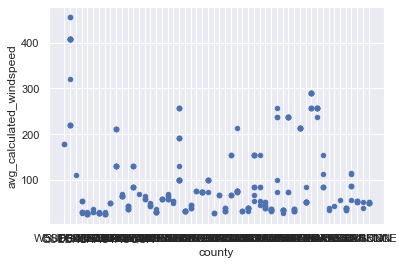

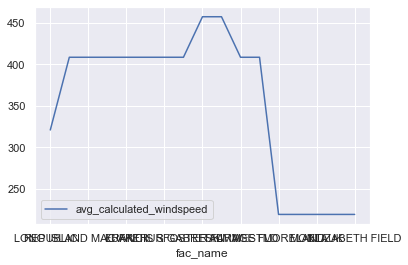

In [79]:
# Modelings
# 4. Peform clustering on the accounts of factors for airports.(Kmeans, KNN, )

# visual analysis
import matplotlib.pyplot as plt

visual_df = final_dataset_with_speed_and_airport.copy()
visual_df.avg_calculated_windspeed = visual_df.avg_calculated_windspeed*100
#print(visual_df)
visual_df = visual_df.drop(columns=['ref_point_lat', 'ref_point_lon', 'objectid','lat', 'lon', 'loc_id', 'region_code', 'state_name'], axis=1)
print(visual_df)
plt.figure()
visual_df.plot(x='county',y='avg_calculated_windspeed', kind='scatter')
df_albany = visual_df[visual_df.county == 'SUFFOLK']
df_albany.plot(x='fac_name',y='avg_calculated_windspeed', kind='line')

Clustering Alogs: OPTICS

OPTICS clustering (where OPTICS is short for Ordering Points To Identify the Clustering Structure) is a modified version of DBSCAN described above.

We introduce a new algorithm for the purpose of cluster analysis which does not produce a clustering of a data set explicitly; but instead creates an augmented ordering of the database representing its density-based clustering structure. This cluster-ordering contains information which is equivalent to the density-based clusterings corresponding to a broad range of parameter settings.

— OPTICS: ordering points to identify the clustering structure, 1999.

The technique is described in the paper:

OPTICS: ordering points to identify the clustering structure, 1999.
It is implemented via the OPTICS class and the main configuration to tune is the “eps” and “min_samples” hyperparameters.

In [80]:

import sklearn
print(sklearn.__version__)

1.0.1


In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.preprocessing import normalize, StandardScaler

In [82]:
# Handling the missing values if any

airport_dataframe = visual_df.copy()
county_list = visual_df['county'].unique().tolist()

airport_dataframe['Category'] = airport_dataframe.county.astype("category").cat.codes
print(airport_dataframe.isnull().sum())

airport_dataframe_temp = airport_dataframe[['avg_calculated_windspeed','Category']].copy()
print(airport_dataframe_temp.head())


scaler = StandardScaler()
airport_dataframe_scaled = scaler.fit_transform(airport_dataframe_temp)
airport_normalized = normalize(airport_dataframe_scaled)
airport_normalized = pd.DataFrame(airport_normalized)
airport_normalized.columns = airport_dataframe_temp.columns
print(airport_normalized.head())


# Building the OPTICS Clustering model
optics_model = OPTICS(min_samples = 50, xi = 0.05, min_cluster_size = 0.05)
  
# Training the model
optics_model.fit_predict(airport_normalized)

labels_050 = cluster_optics_dbscan(
    reachability=optics_model.reachability_,
    core_distances=optics_model.core_distances_,
    ordering=optics_model.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=optics_model.reachability_,
    core_distances=optics_model.core_distances_,
    ordering=optics_model.ordering_,
    eps=2,
)




# Storing the cluster labels of each point
reachability = optics_model.reachability_[optics_model.ordering_]
labels = optics_model.labels_[optics_model.ordering_]
space = np.arange(len(airport_normalized))

print(len(labels))
print(reachability)


fac_type                    0
county                      0
fac_name                    0
avg_calculated_windspeed    0
date                        0
Category                    0
dtype: int64
   avg_calculated_windspeed  Category
0                     179.4        35
1                     320.9        44
2                     408.5        44
3                     179.4        35
4                     408.5        44
   avg_calculated_windspeed  Category
0                  0.831388  0.555693
1                  0.896866  0.442302
2                  0.942695  0.333655
3                  0.831388  0.555693
4                  0.942695  0.333655
360
[       inf 0.55628715 0.44212765 0.3942684  0.3942684  0.3942684
 0.3942684  0.3942684  0.3942684  0.3942684  0.3942684  0.3942684
 0.3942684  0.3942684  0.3942684  0.3942684  0.3942684  0.3942684
 0.3942684  0.3942684  0.3942684  0.3942684  0.3942684  0.3942684
 0.3942684  0.3942684  0.3942684  0.3942684  0.3942684  0.3942684
 0.3942684  0.394

# DBSCAN at 0.5


Text(0.5, 1.0, 'Clustering at 2.0 epsilon cut\nDBSCAN')

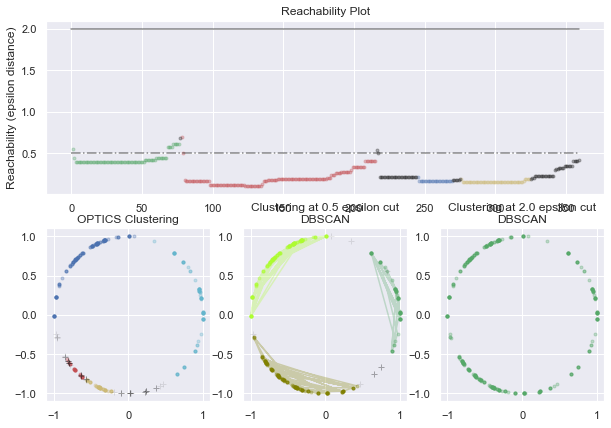

In [83]:
# Defining the framework of the visualization
plt.figure(figsize =(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])


# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")


# Plotting the OPTICS Clustering
colors = ['c.', 'b.', 'r.', 'y.', 'g.']
for Class, colour in zip(range(0, 5), colors):
    Xk = airport_normalized[optics_model.labels_ == Class]
    ax2.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], colour, alpha = 0.3)
      
ax2.plot(airport_normalized.iloc[optics_model.labels_ == -1, 0],
        airport_normalized.iloc[optics_model.labels_ == -1, 1],
       'k+', alpha = 0.1)
ax2.set_title('OPTICS Clustering')


# DBSCAN at 0.5
colors = ["g", "greenyellow", "olive", "r", "b", "c"]
print('# DBSCAN at 0.5')

for klass, color in zip(range(0, 6), colors):
    Xk = airport_normalized[labels_050 == klass]
    ax3.plot(Xk['avg_calculated_windspeed'], Xk['Category'], color, alpha=0.3, marker=".")

ax3.plot(airport_normalized.loc[labels_050 == -1, 'avg_calculated_windspeed'], airport_normalized.loc[labels_050 == -1, 'Category'], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = airport_normalized[labels_200 == klass]
    ax4.plot(Xk['avg_calculated_windspeed'], Xk['Category'], color, alpha=0.3)
ax4.plot(airport_normalized.loc[labels_200 == -1, 'avg_calculated_windspeed'], airport_normalized.loc[labels_200 == -1, 'Category'], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

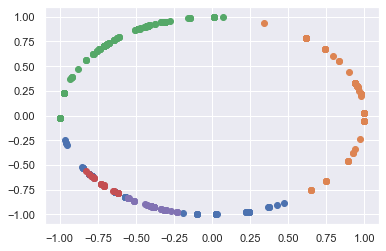

In [84]:

# define dataset
# optics clustering
from numpy import unique
from numpy import where 
from matplotlib import pyplot

# define the model
model = OPTICS(eps=0.8, min_samples = 50, xi = 0.05, min_cluster_size = 0.05)
# fit model and predict clusters
yhat = model.fit_predict(airport_normalized)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(airport_normalized.loc[row_ix, 'avg_calculated_windspeed'], airport_normalized.loc[row_ix, 'Category'])
# show the plot
pyplot.show()


In [85]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [86]:
airport_dataframe2 = visual_df.copy()
airport_dataframe2['Category'] = airport_dataframe2.county.astype("category").cat.codes
print(airport_dataframe2.isnull().sum())

airport_dataframe_temp2 = airport_dataframe2[['avg_calculated_windspeed','Category']].copy()
print(airport_dataframe_temp2)

fac_type                    0
county                      0
fac_name                    0
avg_calculated_windspeed    0
date                        0
Category                    0
dtype: int64
     avg_calculated_windspeed  Category
0                       179.4        35
1                       320.9        44
2                       408.5        44
3                       179.4        35
4                       408.5        44
..                        ...       ...
355                      51.8        42
356                      52.4        42
357                      49.5         8
358                      50.3        15
359                      52.4        42

[360 rows x 2 columns]


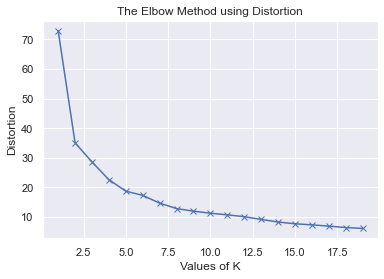

In [87]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(airport_dataframe_temp2)
    distortions.append(sum(np.min(cdist(airport_dataframe_temp2, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / airport_dataframe_temp2.shape[0])
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(cdist(airport_dataframe_temp2, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / airport_dataframe_temp2.shape[0]
    mapping2[k] = kmeanModel.inertia_



plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


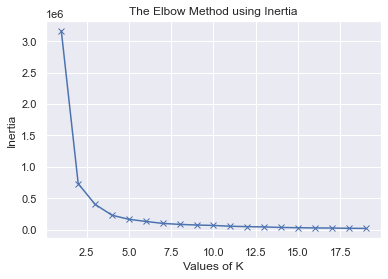

In [88]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [89]:
#Initialize the class object
kmeans = KMeans(n_clusters= 4)
 
#predict the labels of clusters.
label = kmeans.fit_predict(airport_dataframe_temp2)
 
print(label)

[0 0 2 0 2 2 2 2 2 2 2 2 2 2 0 3 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 3 1 0 3 3 1 1 1 3 1 3 3 0 1 1 1 1 1 1 1
 1 3 1 3 1 1 1 1 0 1 0 1 1 1 1 1 1 3 3 1 1 1 1 1 3 1 1 1 1 1 1 3 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 3 1 3 1 3 1 1 1 1 1 1 1 3 3 1 1 3 1 3 0 1 3 1 1 1 1 1 1
 1 3 0 1 1 0 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 3 1 1 1 3 1 1 3 3 1 1 1 1 1 1 1
 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 3 3 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 3 1 0 0 3 1 0 3 3 0 1 1 0 3 1 1 1 1 0 1 3 0 0 0 3 0 3 0
 0 3 0 0 1 0 3 0 0 1 0 0 0 1 0 1 1 1 1 3 1 0 0 3 0 1 1 0 0 0 0 0 3 1 3 0 3
 0 1 0 1 0 0 3 1 1 1 3 0 0 0 0 0 1 3 0 0 1 1 3 1 0 1 1 1 3 1 1 3 1 1 1 1 1
 3 1 3 3 1 3 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


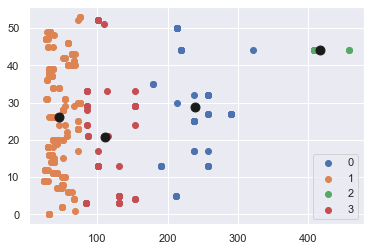

In [90]:

#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(airport_dataframe_temp2.loc[label == i , 'avg_calculated_windspeed'] , airport_dataframe_temp2.loc[label == i , 'Category'] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [91]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [92]:
ms = MeanShift()
ms.fit(airport_dataframe_temp2)
cluster_centers = ms.cluster_centers_
print(cluster_centers)

[[ 50.77932331  25.89849624]
 [237.04210526  28.47368421]
 [417.37272727  44.        ]]


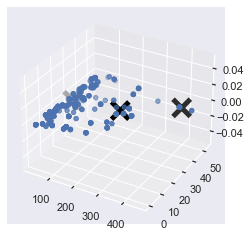

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(airport_dataframe_temp2['avg_calculated_windspeed'], airport_dataframe_temp2['Category'], marker='o')
ax.scatter(cluster_centers[:,0], cluster_centers[:,1], marker='x', color='black', s=300, linewidth=5, zorder=10)
plt.show()

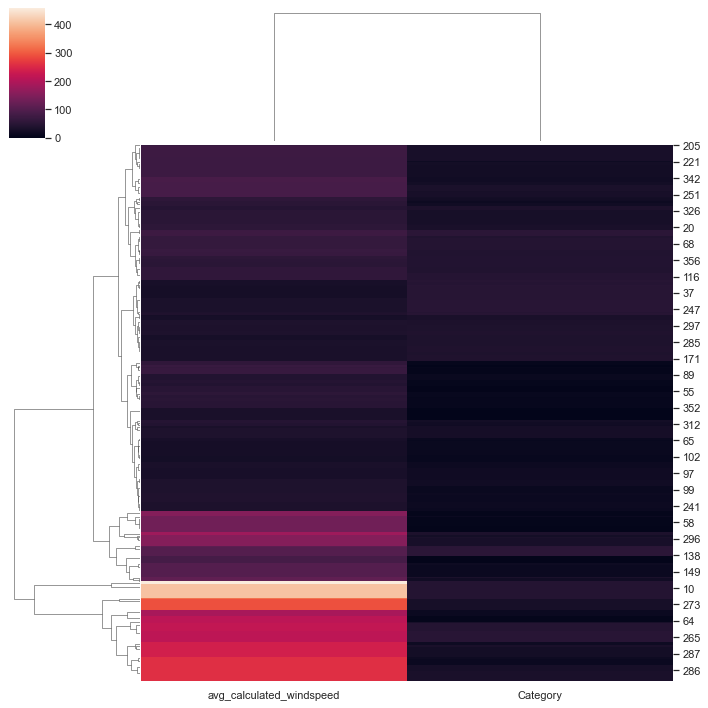

In [111]:
import seaborn as sns; sns.set_theme(color_codes=True)
airport_dataframe2.head()

#air = airport_dataframe2.pop("fac_type")
#airname = airport_dataframe2.pop("fac_name")
#print(airname)

Cou = airport_dataframe2.pop("county")
#print(Cou)

g = sns.clustermap(airport_dataframe_temp2)

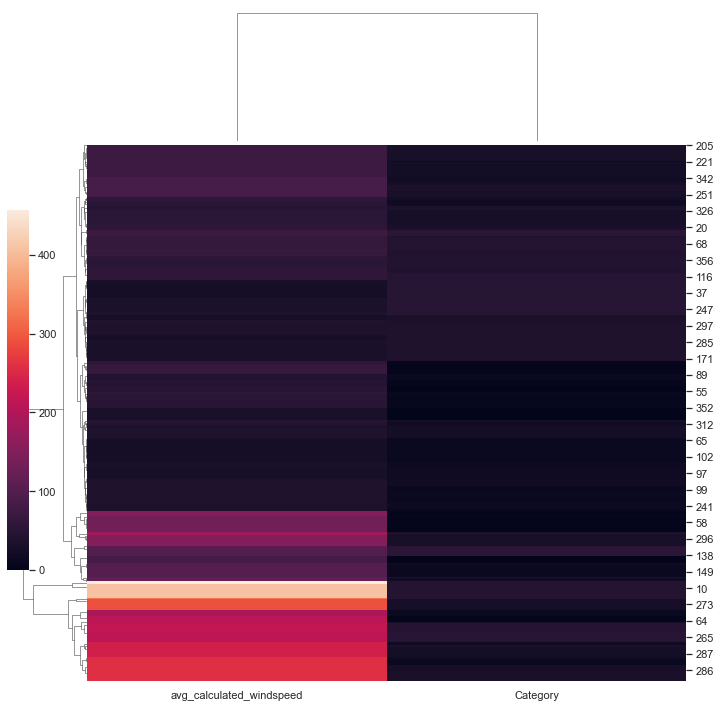

In [121]:
g = sns.clustermap(airport_dataframe_temp2,
                   figsize=(10, 10),
                   row_cluster=True,
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(0, 0.2, .03, .5))#Change the size and layout of the figure.

        

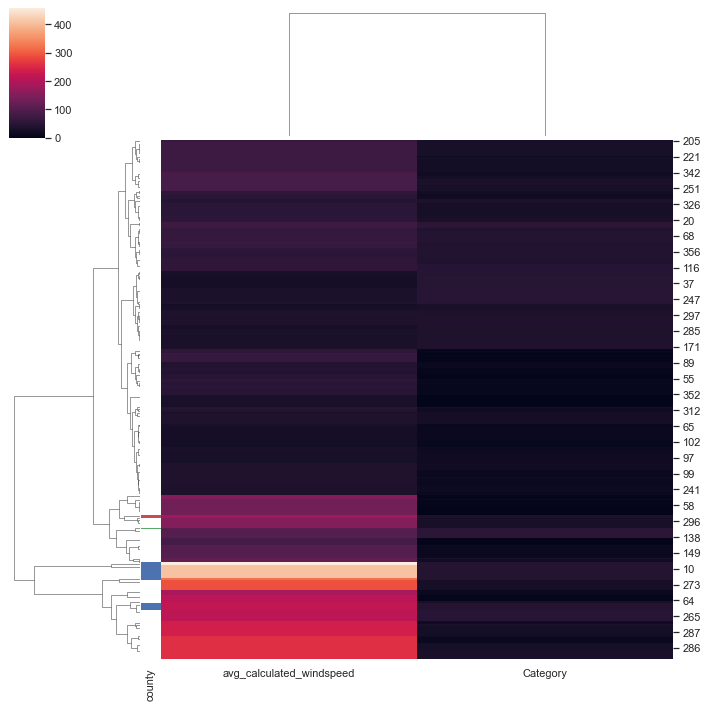

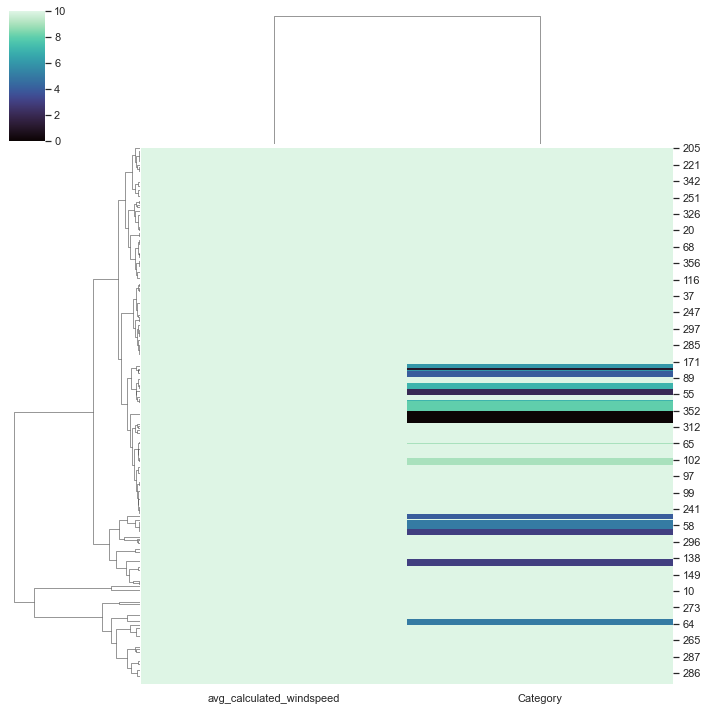

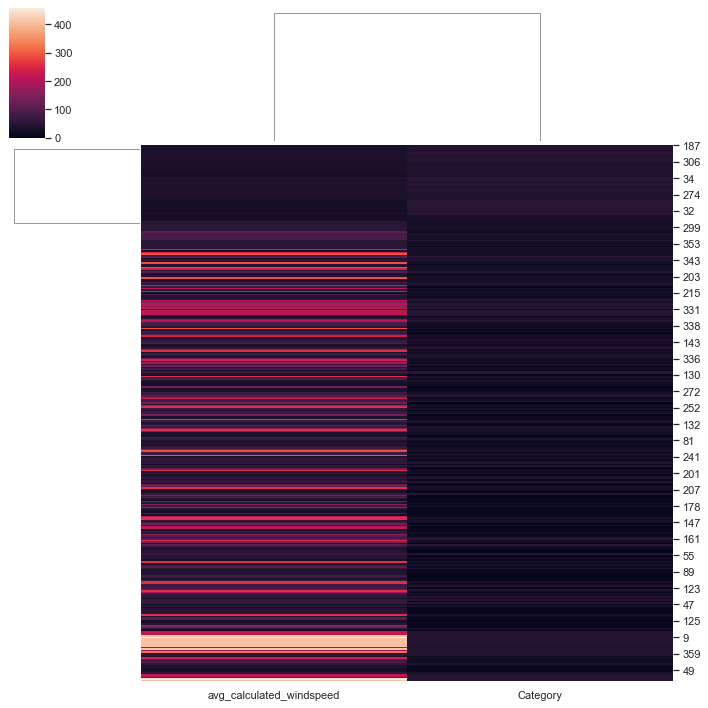

In [124]:
lut = dict(zip(Cou.unique(), "rbg"))
row_colors = Cou.map(lut)
g = sns.clustermap(airport_dataframe_temp2, row_colors=row_colors)
g = sns.clustermap(airport_dataframe_temp2, cmap="mako", vmin=0, vmax=10)


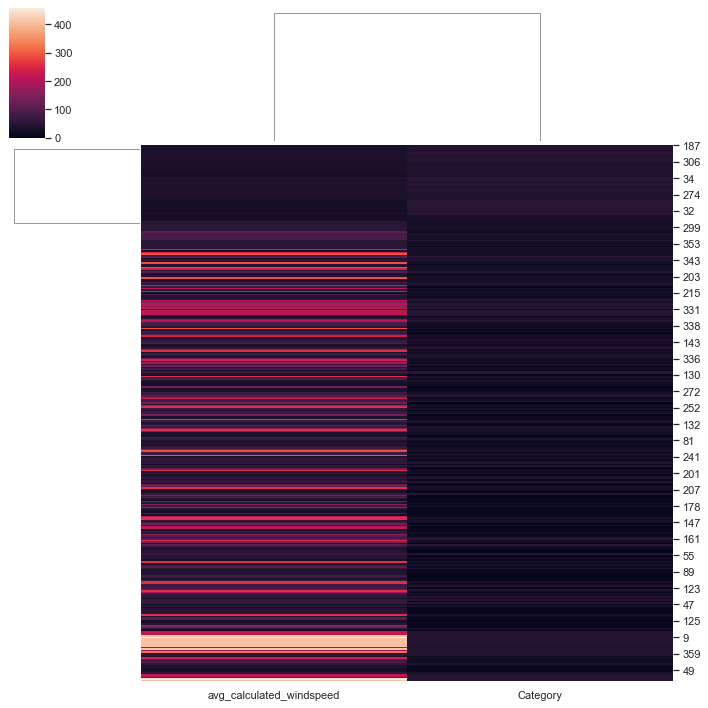

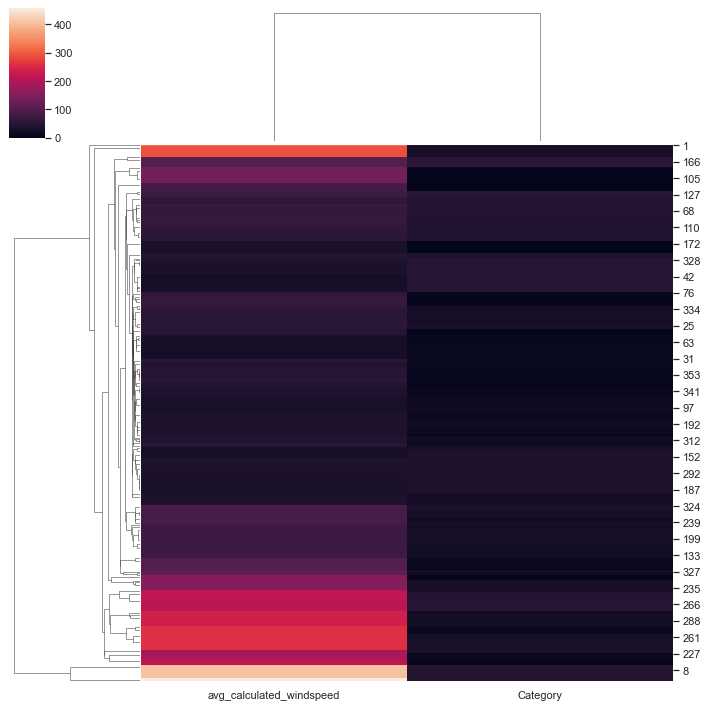

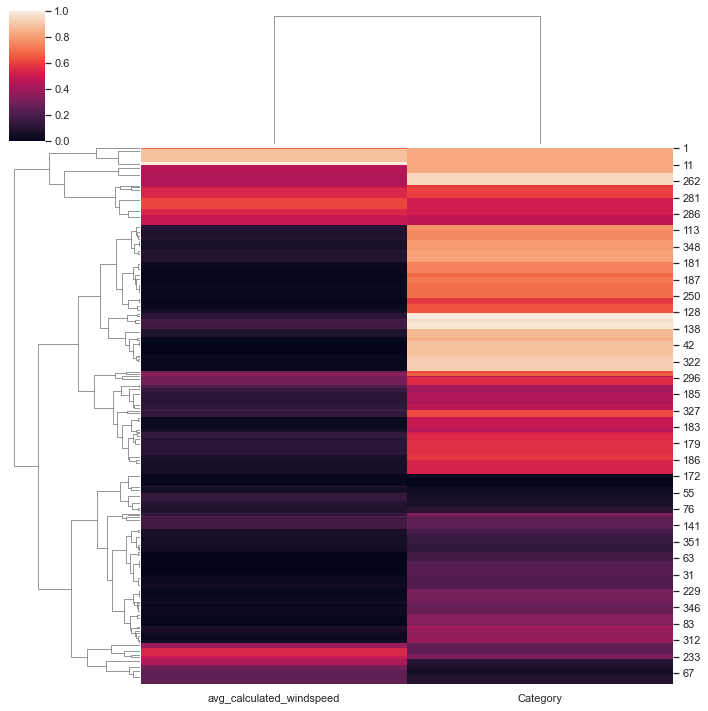

In [126]:
g = sns.clustermap(airport_dataframe_temp2, metric="correlation")
g = sns.clustermap(airport_dataframe_temp2, method="single")
g = sns.clustermap(airport_dataframe_temp2, standard_scale=1)

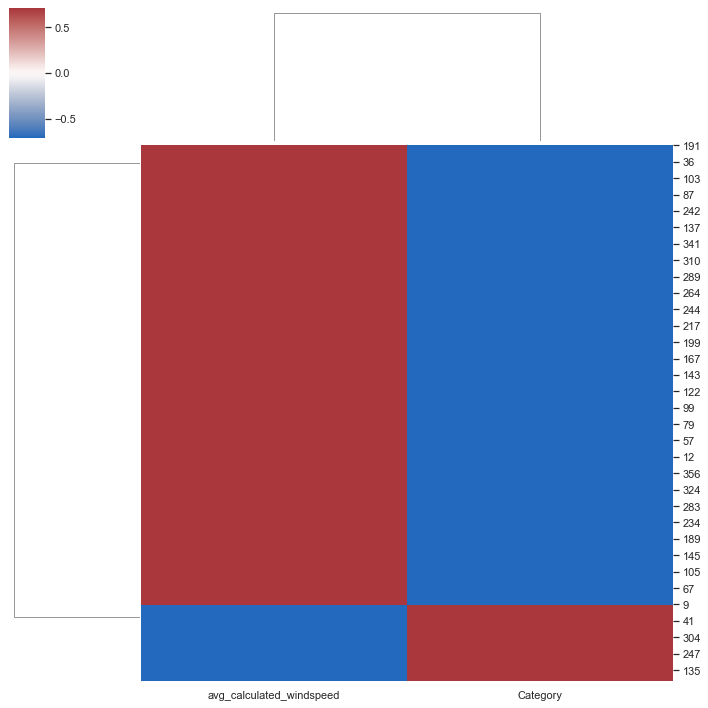

In [127]:
#Normalize the data within the rows
g = sns.clustermap(airport_dataframe_temp2, z_score=0, cmap="vlag")